# **Randomize data**

This script is for randomizing data to enable blinded analysis.

In [1]:
import pandas as pd
import numpy as np
import random
import os

In [6]:
assignment_save_dir = '../data/assignment/'
assignment_save_file = 'assignment.txt'
mindware_dir = '../data/mindware_processed/'
data_dir = '../data/preprocessed/'
conditions = ["positive", "negative", "neutral"]

## **Generate random number for each condition**

In [ ]:
# conditions and numbers to assign
numbers = [1, 2, 3]

# randomly shuffle the numbers
random.shuffle(numbers)

# assign the randomly shuffled numbers to the conditions
random_assignment = dict(zip(conditions, numbers))

# save the random assignment to a file
if  not os.path.exists(assignment_save_dir):
    os.makedirs(assignment_save_dir)
with open(assignment_save_dir + assignment_save_file, 'w') as f:
    for key in random_assignment.keys():
        f.write("%s,%s\n"%(key, random_assignment[key]))

## **Load Mindware IBI data and randomize file names**

In [7]:
def process_mindware_ibi(df: pd.DataFrame) -> tuple[np.ndarray, int]:
    # List to store the IBI values
    ibi_array = []
    # Offset of the first IBI
    first_ibi_offset = None

    # Process each segment
    for col in df.columns:
        # Drop NaN values and get the segment data
        segment_data = df[col].dropna().values

        if len(segment_data) == 0:
            continue
        
        # The first and last values are the start and end offsets
        start_offset = segment_data[0]
        end_offset = segment_data[-1]
        
        # Extract actual IBIs (excluding the start and end offsets)
        true_ibi = segment_data[1:-1] if len(segment_data) > 2 else []

        # Add the start offset to the previous segment's last offset to calculate IBI
        if len(ibi_array) > 0:
            ibi_array[-1] += start_offset
        else:
            first_ibi_offset = int(start_offset)

        # Add actual IBIs to the list
        ibi_array.extend(true_ibi)
        
        # Add the end offset to the list
        ibi_array.append(end_offset)

    ibi_array = np.array(ibi_array)
    # Remove the very last IBI
    ibi_array = ibi_array[:-1]
    
    return ibi_array, first_ibi_offset

In [36]:
mindware_files = os.listdir(mindware_dir)
mindware_files = [f for f in mindware_files if 'HRV Analysis' in f]
preprocessed_files = os.listdir(data_dir)
preprocessed_files = [f for f in preprocessed_files if 'ECG' in f]

### For sessions 'NN' and 'NY'

In [114]:
# for condition in conditions:
#     for sessions in ['NN', 'NY']:
condition = 'positive'
session = 'NY'
p1 = 'YW'
p2 = 'NY'

mindware_files_session = [f for f in mindware_files if session in f]
mindware_files_condition = [f for f in mindware_files_session if condition in f]
preprocessed_files_session = [f for f in preprocessed_files if session in f]
preprocessed_files_condition = [f for f in preprocessed_files_session if condition in f]
mw_file_p1 = [f for f in mindware_files_condition if p1 in f][0]
mw_file_p2 = [f for f in mindware_files_condition if p1 not in f][0]
preprocessed_file_p1 = [f for f in preprocessed_files_condition if p1 in f][0]
preprocessed_file_p2 = [f for f in preprocessed_files_condition if p1 not in f][0]

mw_df_p1 = pd.read_excel(mindware_dir + mw_file_p1, sheet_name='IBI')
mw_df_p2 = pd.read_excel(mindware_dir + mw_file_p2, sheet_name='IBI')
ibi_p1, first_ibi_offset_p1 = process_mindware_ibi(mw_df_p1)
ibi_p2, first_ibi_offset_p2 = process_mindware_ibi(mw_df_p2)
elapsed_time_p1 = first_ibi_offset_p1 + np.cumsum(ibi_p1)
elapsed_time_p2 = first_ibi_offset_p2 + np.cumsum(ibi_p2)

preprocessed_df_p1 = pd.read_csv(data_dir + preprocessed_file_p1)
preprocessed_df_p2 = pd.read_csv(data_dir + preprocessed_file_p2)
preprocessed_df_p1['timestamp'] = pd.to_datetime(preprocessed_df_p1['timestamp'])
preprocessed_df_p2['timestamp'] = pd.to_datetime(preprocessed_df_p2['timestamp'])

first_time_p1 = preprocessed_df_p1['timestamp'].iloc[0]
first_time_p2 = preprocessed_df_p2['timestamp'].iloc[0]
last_time_p1 = preprocessed_df_p1['timestamp'].iloc[-1]
last_time_p2 = preprocessed_df_p2['timestamp'].iloc[-1]

mw_timestamps_p1 = [first_time_p1 + pd.Timedelta(milliseconds=t) for t in elapsed_time_p1]
mw_timestamps_p2 = [first_time_p2 + pd.Timedelta(milliseconds=t) for t in elapsed_time_p2]

ibi_df_p1 = pd.DataFrame({'IBI': ibi_p1, 'timestamp': mw_timestamps_p1})
ibi_df_p2 = pd.DataFrame({'IBI': ibi_p2, 'timestamp': mw_timestamps_p2})

In [115]:
# Align time range
#first_timestamp = max(first_time_p1, first_time_p2)
#last_timestamp = min(last_time_p1, last_time_p2)
first_timestamp = pd.to_datetime('2024-11-19 15:45:36.987').tz_localize('America/New_York')
last_timestamp = pd.to_datetime('2024-11-19 15:55:26.133').tz_localize('America/New_York')

ibi_df_p1 = ibi_df_p1.loc[(ibi_df_p1['timestamp'] >= first_timestamp) & (ibi_df_p1['timestamp'] <= last_timestamp)].reset_index(drop=True)
ibi_df_p2 = ibi_df_p2.loc[(ibi_df_p2['timestamp'] >= first_timestamp) & (ibi_df_p2['timestamp'] <= last_timestamp)].reset_index(drop=True)
preprocessed_df_p1 = preprocessed_df_p1.loc[(preprocessed_df_p1['timestamp'] >= first_timestamp) & (preprocessed_df_p1['timestamp'] <= last_timestamp)].reset_index(drop=True)
preprocessed_df_p2 = preprocessed_df_p2.loc[(preprocessed_df_p2['timestamp'] >= first_timestamp) & (preprocessed_df_p2['timestamp'] <= last_timestamp)].reset_index(drop=True)

preprocessed_df_p1['time'] = (preprocessed_df_p1['timestamp'] - first_timestamp).dt.total_seconds() * 1000
preprocessed_df_p2['time'] = (preprocessed_df_p2['timestamp'] - first_timestamp).dt.total_seconds() * 1000
ibi_df_p1['time'] = (ibi_df_p1['timestamp'] - first_timestamp).dt.total_seconds() * 1000
ibi_df_p2['time'] = (ibi_df_p2['timestamp'] - first_timestamp).dt.total_seconds() * 1000

ibi_df_p1.to_csv(f'{mindware_dir}{session}_mindware_IBI_{p1}_{condition}.csv', index=False)
ibi_df_p2.to_csv(f'{mindware_dir}{session}_mindware_IBI_{p2}_{condition}.csv', index=False)

preprocessed_df_p1.to_csv(f'{data_dir}{session}_preprocessed_{p1}_{condition}.csv', index=False)
preprocessed_df_p2.to_csv(f'{data_dir}{session}_preprocessed_{p2}_{condition}.csv', index=False)

In [65]:
first_time_p1

Timestamp('2024-10-27 18:39:34.816680908-0400', tz='UTC-04:00')

### For sessions 'MG' and 'VM'

In [104]:
# for condition in conditions:
#     for sessions in ['NN', 'NY']:
session = 'MG'
p1 = 'YW'
p2 = 'MG'

mindware_files_session = [f for f in mindware_files if session in f]
preprocessed_files_session = [f for f in preprocessed_files if session in f]
mw_file_p1 = [f for f in mindware_files_session if p1 in f][0]
mw_file_p2 = [f for f in mindware_files_session if p1 not in f][0]
preprocessed_file_p1 = [f for f in preprocessed_files_session if p1 in f][0]
preprocessed_file_p2 = [f for f in preprocessed_files_session if p1 not in f][0]

mw_df_p1 = pd.read_excel(mindware_dir + mw_file_p1, sheet_name='IBI')
mw_df_p2 = pd.read_excel(mindware_dir + mw_file_p2, sheet_name='IBI')
ibi_p1, first_ibi_offset_p1 = process_mindware_ibi(mw_df_p1)
ibi_p2, first_ibi_offset_p2 = process_mindware_ibi(mw_df_p2)
elapsed_time_p1 = first_ibi_offset_p1 + np.cumsum(ibi_p1)
elapsed_time_p2 = first_ibi_offset_p2 + np.cumsum(ibi_p2)

preprocessed_df_p1 = pd.read_csv(data_dir + preprocessed_file_p1)
preprocessed_df_p2 = pd.read_csv(data_dir + preprocessed_file_p2)
preprocessed_df_p1['timestamp'] = pd.to_datetime(preprocessed_df_p1['timestamp'])
preprocessed_df_p2['timestamp'] = pd.to_datetime(preprocessed_df_p2['timestamp'])

first_time_p1 = preprocessed_df_p1['timestamp'].iloc[0]
first_time_p2 = preprocessed_df_p2['timestamp'].iloc[0]
last_time_p1 = preprocessed_df_p1['timestamp'].iloc[-1]
last_time_p2 = preprocessed_df_p2['timestamp'].iloc[-1]

mw_timestamps_p1 = [first_time_p1 + pd.Timedelta(milliseconds=t) for t in elapsed_time_p1]
mw_timestamps_p2 = [first_time_p2 + pd.Timedelta(milliseconds=t) for t in elapsed_time_p2]

ibi_df_p1 = pd.DataFrame({'IBI': ibi_p1, 'timestamp': mw_timestamps_p1})
ibi_df_p2 = pd.DataFrame({'IBI': ibi_p2, 'timestamp': mw_timestamps_p2})

In [85]:
print(first_time_p1, first_time_p2)

2024-11-25 13:36:28.501770020-05:00 2024-11-25 13:35:55.915344238-05:00


In [75]:
from matplotlib import pyplot as plt
def plot_acc(preprocessed_df_p1, preprocessed_df_p2):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 8))
    axes = axes.flatten()
    axes[0].plot(preprocessed_df_p1['timestamp'], preprocessed_df_p1['acc_x'], label='acc_x')
    axes[0].plot(preprocessed_df_p1['timestamp'], preprocessed_df_p1['acc_y'], label='acc_y')
    axes[0].plot(preprocessed_df_p1['timestamp'], preprocessed_df_p1['acc_z'], label='acc_z')
    axes[1].plot(preprocessed_df_p2['timestamp'], preprocessed_df_p2['acc_x'], label='acc_x')
    axes[1].plot(preprocessed_df_p2['timestamp'], preprocessed_df_p2['acc_y'], label='acc_y')
    axes[1].plot(preprocessed_df_p2['timestamp'], preprocessed_df_p2['acc_z'], label='acc_z')

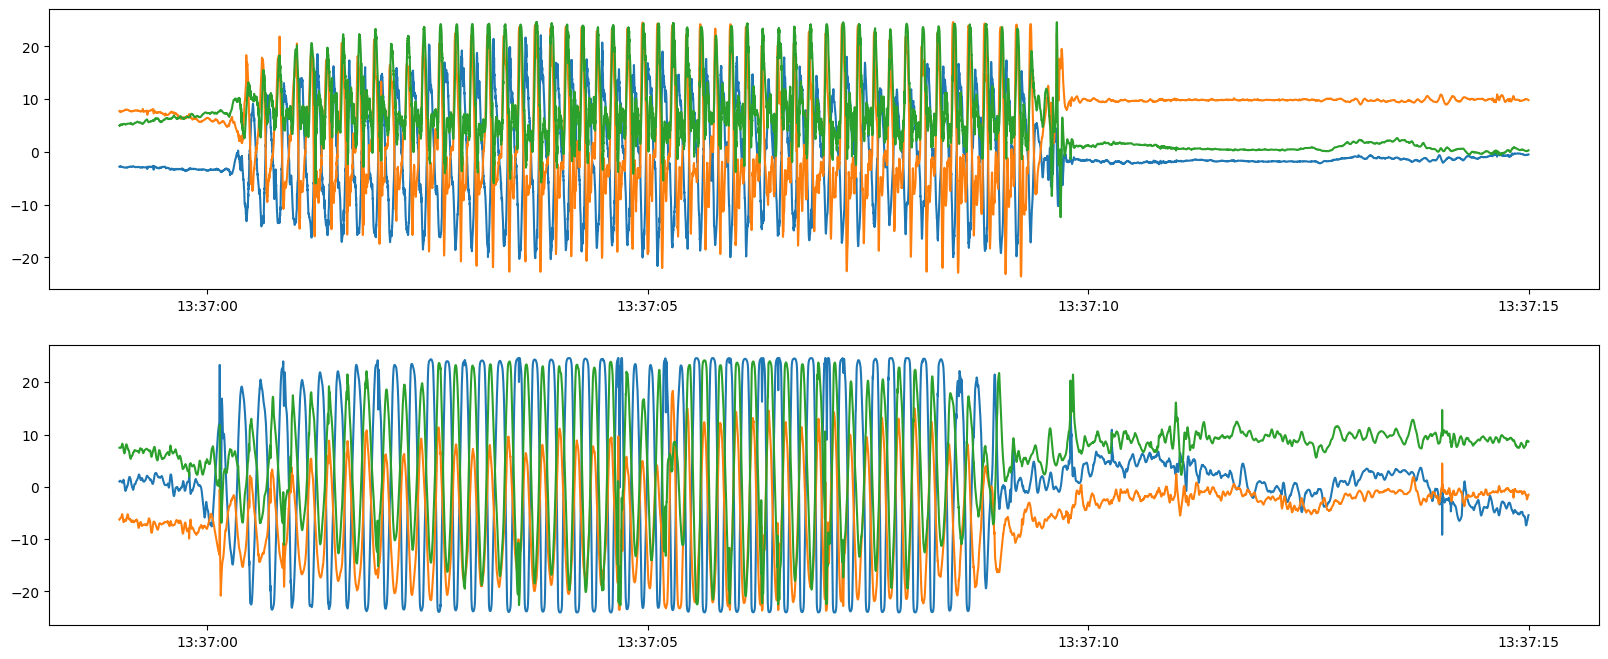

In [89]:
start_time = pd.to_datetime('2024-11-25 13:36:59').tz_localize('America/New_York')
end_time = pd.to_datetime('2024-11-25 13:37:15').tz_localize('America/New_York')
plot_acc(preprocessed_df_p1[(preprocessed_df_p1['timestamp'] > start_time) & (preprocessed_df_p1['timestamp'] < end_time)], preprocessed_df_p2[(preprocessed_df_p2['timestamp'] > start_time) & (preprocessed_df_p2['timestamp'] < end_time)])

In [94]:
def plot_ecg(preprocessed_df_p1, preprocessed_df_p2, start_time=None, end_time=None):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 8))
    axes = axes.flatten()
    df_p1 = preprocessed_df_p1.copy()
    df_p2 = preprocessed_df_p2.copy()
    if start_time is not None and end_time is not None:
        df_p1 = preprocessed_df_p1[(preprocessed_df_p1['timestamp'] > start_time) & (preprocessed_df_p1['timestamp'] < end_time)]
        df_p2 = preprocessed_df_p2[(preprocessed_df_p2['timestamp'] > start_time) & (preprocessed_df_p2['timestamp'] < end_time)]
    axes[0].plot(df_p1['timestamp'], df_p1['ecg_filtered'], label='ecg_p1')
    axes[1].plot(df_p2['timestamp'], df_p2['ecg_filtered'], label='ecg_p2')

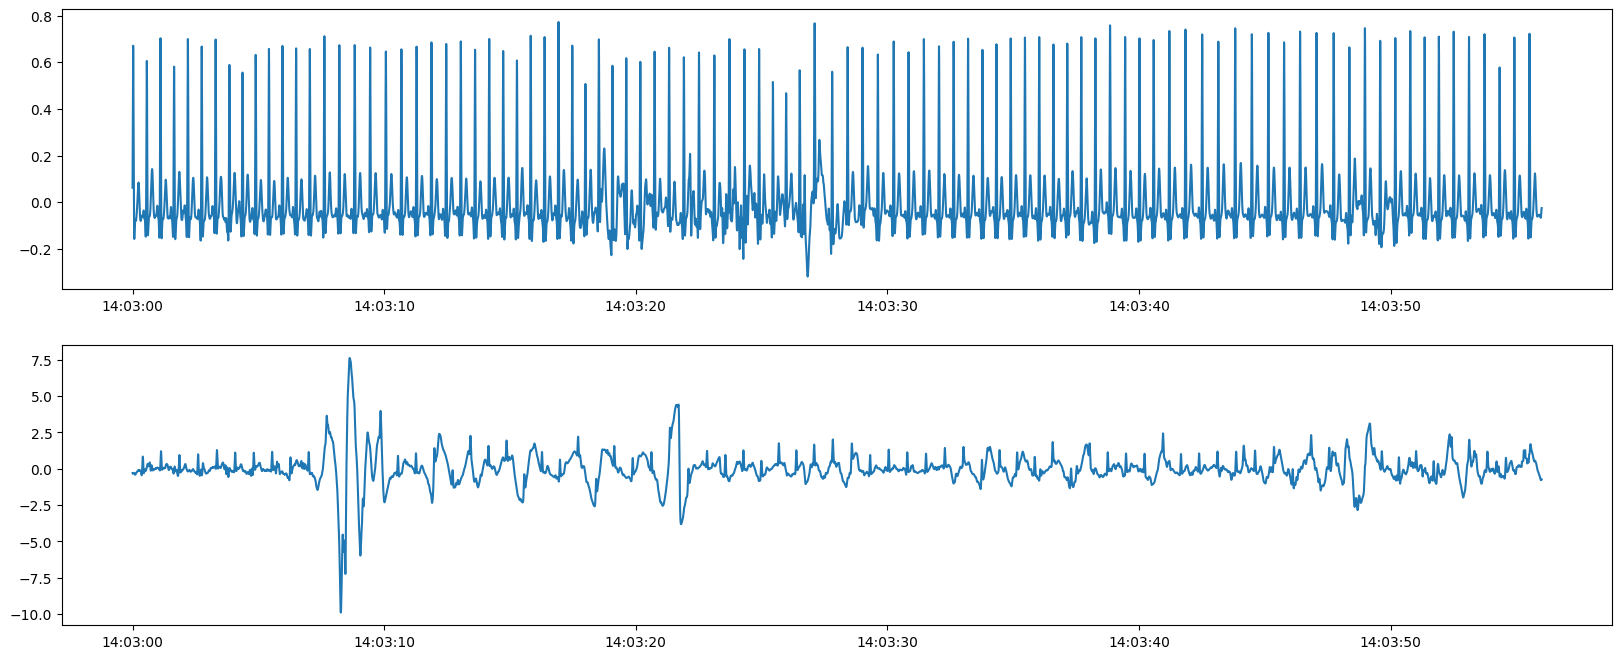

In [101]:
start_time = pd.to_datetime('2024-11-25 14:03:00').tz_localize('America/New_York')
end_time = pd.to_datetime('2024-11-25 14:03:56').tz_localize('America/New_York')
plot_ecg(preprocessed_df_p1, preprocessed_df_p2, start_time, end_time)

In [105]:
# Align time range
#first_timestamp = max(first_time_p1, first_time_p2)
#last_timestamp = min(last_time_p1, last_time_p2)
first_timestamp = pd.to_datetime('2024-11-21 10:53:58.519').tz_localize('America/New_York')
last_timestamp = pd.to_datetime('2024-11-21 11:30:36.528').tz_localize('America/New_York')

ibi_df_p1 = ibi_df_p1.loc[(ibi_df_p1['timestamp'] >= first_timestamp) & (ibi_df_p1['timestamp'] <= last_timestamp)].reset_index(drop=True)
ibi_df_p2 = ibi_df_p2.loc[(ibi_df_p2['timestamp'] >= first_timestamp) & (ibi_df_p2['timestamp'] <= last_timestamp)].reset_index(drop=True)
preprocessed_df_p1 = preprocessed_df_p1.loc[(preprocessed_df_p1['timestamp'] >= first_timestamp) & (preprocessed_df_p1['timestamp'] <= last_timestamp)].reset_index(drop=True)
preprocessed_df_p2 = preprocessed_df_p2.loc[(preprocessed_df_p2['timestamp'] >= first_timestamp) & (preprocessed_df_p2['timestamp'] <= last_timestamp)].reset_index(drop=True)

preprocessed_df_p1['time'] = (preprocessed_df_p1['timestamp'] - first_timestamp).dt.total_seconds() * 1000
preprocessed_df_p2['time'] = (preprocessed_df_p2['timestamp'] - first_timestamp).dt.total_seconds() * 1000
ibi_df_p1['time'] = (ibi_df_p1['timestamp'] - first_timestamp).dt.total_seconds() * 1000
ibi_df_p2['time'] = (ibi_df_p2['timestamp'] - first_timestamp).dt.total_seconds() * 1000

ibi_df_p1.to_csv(f'{mindware_dir}{session}_mindware_IBI_{p1}.csv', index=False)
ibi_df_p2.to_csv(f'{mindware_dir}{session}_mindware_IBI_{p2}.csv', index=False)

preprocessed_df_p1.to_csv(f'{data_dir}{session}_preprocessed_{p1}.csv', index=False)
preprocessed_df_p2.to_csv(f'{data_dir}{session}_preprocessed_{p2}.csv', index=False)